# Machine Learning 2
## Regression task
### Tomasz Starakiewicz
### 28.02.2023

In [20]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split

#### Data



#### Problem



In [8]:
df = pd.read_csv('../data/audi.csv')
print('Observations:', len(df))
print('NAs in target variable:', df['price'].isna().sum())

Observations: 10668
NAs in target variable: 0


The dataset contains 10k observations, all with a proper target variable.

#### Data partitioning

We partition the data before EDA, to ensure no bias finds its way into the model building.

In [9]:
train, test = train_test_split(df, test_size=0.2, random_state=123)
X_train = train.drop(columns='price')
y_train = train['price']

X_test = test.drop(columns='price')
y_test = test['price']

#### Exploratory Data Analysis

There appear to be 5 numerical features:
- interval: year
- ratio: mileage, tax, mpg, engineSize

However, we need to verify if some of them are not better treated as ordinal variables with low cardinality, e.g. engineSize, since they are likely to have only a few distinct values.

In [17]:
display(X_train.describe())

,year,mileage,tax,mpg,engineSize
count,8534.000000,8534.000000,8534.000000,8534.000000,8534.000000
mean,2017.103000,24790.511601,125.984298,50.759655,1.927795
std,2.173977,23509.775884,67.374140,12.949907,0.602725
min,1997.000000,1.000000,0.000000,18.900000,0.000000
25%,2016.000000,6000.000000,125.000000,40.900000,1.500000
50%,2017.000000,19010.000000,145.000000,49.600000,2.000000
75%,2019.000000,36275.250000,145.000000,58.900000,2.000000
max,2020.000000,323000.000000,580.000000,188.300000,6.300000


There are 3 categorical features:
- low cardinality: transimission, fuelType
- high cardinality: model

With 'model' variable, we need to definitely explore whether only the top groups should be kept distinct, the rest grouped into 'other'.

In [18]:
display(X_train.describe(include='O'))

,model,transmission,fuelType
count,8534,8534,8534
unique,26,3,3
top,A3,Manual,Diesel
freq,1559,3475,4424


All of the variables represent some degree of skewness and outliers, so for some models variable transformations will be necessary.

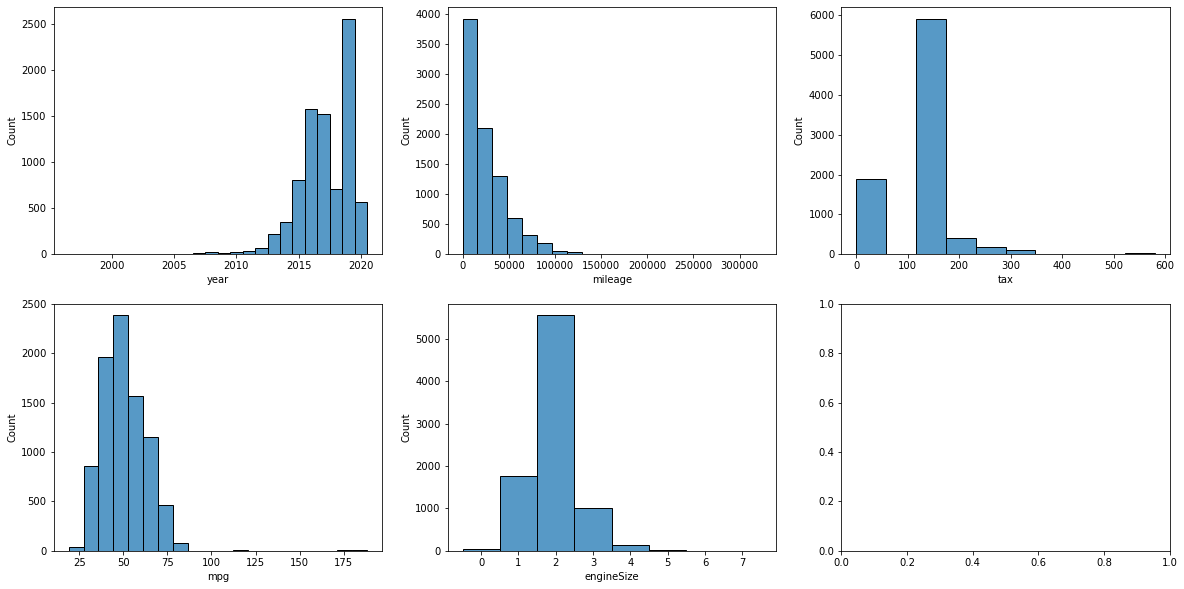

In [37]:
fig, axs = plt.subplots(2, 3, figsize=(20, 10))

sns.histplot(X_train['year'], discrete=True, ax=axs[0][0])
sns.histplot(X_train['mileage'], bins=20, ax=axs[0][1])
sns.histplot(X_train['tax'], bins=10, ax=axs[0][2])
sns.histplot(X_train['mpg'], bins=20, ax=axs[1][0])
sns.histplot(X_train['engineSize'], discrete=True, ax=axs[1][1])
plt.show()

Few values of engine size and tax turn out not to be as big of a problem as expected.

In [42]:
print('Number of distinct engine size values:', len(X_train['engineSize'].value_counts()))
print('Number of distinct tax values:', len(X_train['tax'].value_counts()))

Number of distinct engine size values: 19
Number of distinct tax values: 33


There are 33 distinct models, but 10 of them account for 95% of all observations.

In [58]:
X_train['model'].value_counts()[:10]

print(f'Top 10 models account for {X_train["model"].value_counts()[:10].sum() / len(X_train):.2f} of observations')

Top 10 models account for 0.95 of observations


While transmission is relatively balanced, in case of fuel type there is significant disproportion, there are hardly any Hybrids. This might cause some issues during cross-validation, there is a small possibility all of these will end up in one of the validation folds.

In [63]:
display(X_train['transmission'].value_counts())

display(X_train['fuelType'].value_counts())

Manual       3475
Semi-Auto    2877
Automatic    2182
Name: transmission, dtype: int64

Diesel    4424
Petrol    4088
Hybrid      22
Name: fuelType, dtype: int64

#### Variable transformation


#### Variable selection


#### Cross-validation

#### Model assessment and comparison

#### Summary